# Workshop AI Fundamentals: linear regression and clustering

In this workshop you will get a taste of what automated pattern recognition can do. We will be using the Palmer Penguins data set to see if we can predict characteristics of penguins using linear regression and to see if we can predict the species of a penguin based on these characteristics.

For more information on this data set see: https://allisonhorst.github.io/palmerpenguins/articles/intro.html

To run this notebook on Google Colab, please click the button below:



<a href="https://colab.research.google.com/github/mcdejonge/ws-ai-fundamentals-msi/blob/main/regression_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Preliminaries. Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import os

## Step 1: read in the data

In [18]:
# Check if the notebook is running on Google Colab
if 'COLAB_GPU' in os.environ:
    # Running on Google Colab; install loguru
    df = pd.read_csv("https://raw.githubusercontent.com/mcdejonge/ws-ai-fundamentals-msi/refs/heads/main/data/penguins_size.csv")
else:
    df = pd.read_csv("data/penguins_size.csv")
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


We see 7 columns containing information on 3 species collected on 3 different islands. Presumably the meaning of most of the fields is clear. "Culmen length" is the length of the top of a penguin's beak. "Culmen depth" is the "height" of a penguin's beak, measured from top to bottom.

<img src="https://raw.githubusercontent.com/mcdejonge/ws-ai-fundamentals-msi/refs/heads/main/img/culmen_explanation.jpeg" width="300px">

Not all the rows contain all of the data (you can see NaN - "not a number" values above). A "proper" data scientist would perform a statistical analysis to determine how to fix this.

We are just starting out, so we will simply throw these rows away.

In [19]:
df = df.dropna()

## Step 2: linear regression

First we will see an example of a linear regression model. We are going to check if flipper length is correlated linearly to culmen length.

First we make a simple scatter plot where we plot the two variables against each other.

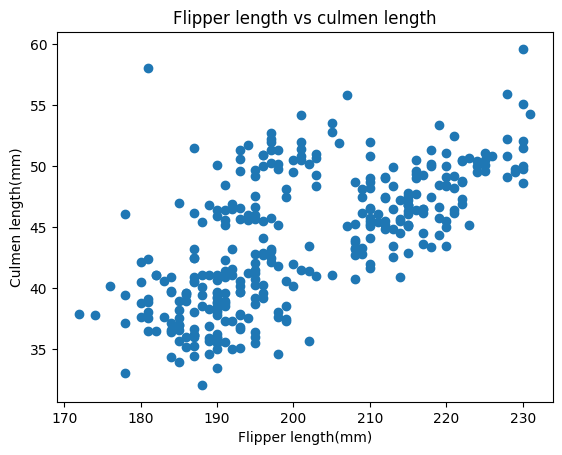

In [20]:
fig, ax = plt.subplots()
plt.scatter(df['flipper_length_mm'], df['culmen_length_mm'])
ax.set_title("Flipper length vs culmen length")
ax.set_ylabel("Culmen length(mm)")
ax.set_xlabel("Flipper length(mm)")
plt.show()

If you look through your eyelashes at this graph (a valid data science technique!) there seems to be a pattern, albeit one that isn't very strong.

A data scientist would calculate the correlation between the two variables. For good measure, here it is:

In [21]:
print(f"The correlation between flipper length and culmen length is {df['flipper_length_mm'].corr(df['culmen_length_mm']):.2f}")


The correlation between flipper length and culmen length is 0.65


The Pearson's Correlation Coefficient (as it is called) is 0.65. This is not great, but not terrible either (often in science we say a correlation > 0.7 is "strong").

It should be possible to create a somewhat usable linear model that can predict culmen length based on flipper length. This way, if we find a penguin footprint and measure it, we can predict the length of the beak of the penguin that made this footprint.

To make a model we need to do three things:

1. Split up the data set into training data and test data. The training data is for *training* the model and the test data is for *testing* how well the model performs on data it hasn't seen yet.
2. Train the model. "Training" means the model will find the values of $m$ and $b$ in the formula $y = mx + b$ that describes the linear relationship between culmen length ($y$) and flipper length ($x$).
3. Test the model. "Testing" means we feed the model our test data and measure the difference between the values it predicts and the real values.

### Training the model

First we create the test and training data sets and train the model.

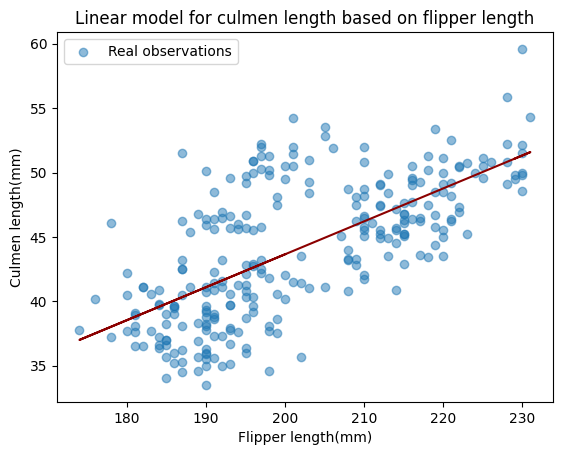

In [22]:
# Create training data and test data
df_train, df_test = train_test_split(df, test_size = 0.2)

# Create the model using the training data
model = LinearRegression()
model.fit(df_train[['flipper_length_mm']], df_train[['culmen_length_mm']])

# Let's see what the model looks like. For this we plot the predicted culmen length against the real flipper length.
df_culmen_predict_for_line = model.predict(df_train[['flipper_length_mm']])

fig, ax = plt.subplots()
plt.scatter(df_train['flipper_length_mm'], df_train['culmen_length_mm'], alpha=0.5)
plt.plot(df_train['flipper_length_mm'], df_culmen_predict_for_line, color='darkred')
ax.set_title("Linear model for culmen length based on flipper length")
ax.set_ylabel("Culmen length(mm)")
ax.set_xlabel("Flipper length(mm)")
ax.legend(['Real observations'])
plt.show()

### Test the model

Then we test the model. There are many ways to do this, but the simplest way is to calculate "$R^2" (R Squared aka the "coefficient of determination"). It's basically the square of the correlation coefficient.

In [24]:
# This is how you would generate predictions.
df_culmen_predict = model.predict(df_test[['flipper_length_mm']])
# This is how you calculate how closely the predictions match the actual values
print(f"The R squared score for our model is {model.score(df_test[['flipper_length_mm']], df_test[['culmen_length_mm']]):.2f} (> .7 is often 'good', but in biology lower values can be acceptable).")
print(f"(Interestingly the score for the training data was {model.score(df_train[['flipper_length_mm']], df_train[['culmen_length_mm']]):.2f})")

The R squared score for our model is 0.34 (> .7 is often 'good', but in biology lower values can be acceptable).
(Interestingly the score for the training data was 0.45)


Let's plot the predictions against the test values so we can see what this R^2 score looks like.

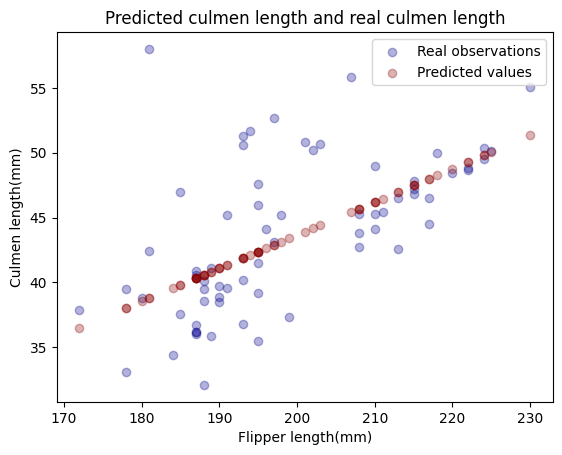

In [25]:
fig, ax = plt.subplots()
plt.scatter(df_test['flipper_length_mm'], df_test['culmen_length_mm'], alpha=0.3, color="darkblue")
plt.scatter(df_test['flipper_length_mm'], df_culmen_predict, alpha=0.3, color="darkred")
# plt.plot(df_train['flipper_length_mm'], df_culmen_predict_for_line, color='darkred')
ax.set_title("Predicted culmen length and real culmen length")
ax.set_ylabel("Culmen length(mm)")
ax.set_xlabel("Flipper length(mm)")
ax.legend(['Real observations', 'Predicted values'])
plt.show()

And there you have it! We have trained a computer to predict (poorly) the length of a penguin's culmen based on the length of its flipper!

### Addendum: split by species

Perhaps there are meaningful differences between different species of penguins. We can try to see what happens if we create models for each species individually.

In [26]:
# Loop through the different species, create models and score them.
for species in df['species'].unique():
    species_model = LinearRegression()
    dftrain_species = df_train[df_train['species'] == species]
    dftest_species = df_test[df_test['species'] == species]
    species_model.fit(dftrain_species[['flipper_length_mm']], dftrain_species[['culmen_length_mm']])
    print(f'The R squared score for a model specific to species {species} is {species_model.score(dftest_species[['flipper_length_mm']], dftest_species[['culmen_length_mm']]):.2f}')

The R squared score for a model specific to species Adelie is 0.17
The R squared score for a model specific to species Chinstrap is 0.01
The R squared score for a model specific to species Gentoo is 0.71


Interesting. It turns out to be easier to predict culmen length based on flipper length for  Gentoo penguins than it is for the other species.

This brings us to our next topic: classification.

## Step 3: Classification

We have seen there is a detectable difference between the three penguin species: culmen length is easier to predict using linear regression for Gentoo penguins than for Chinstrap penguins while for Adelie penguins such a prediction is basically impossible.

This suggests we may be able to predict the penguin *species* using this data.

Predicting to which *class* a data point belongs is called *classification*. We will look at two examples of clustering: *supervised* and *unsupervised*.

**Supervised** machine learning means you tell the computer what you want to predict. The computer will attempt to find an algorithm that can do the prediction. An example is asking it to predict culmen length based on flipper length, like we did before.

**Unsupervised** machine learning is when you give the computer a set of data and you ask it to find patterns without you telling it what to predict (hence "unsupervised"). Unsupervised machine learning is often used to find *classes* or *clusters*, for example in  marketing where a clustering algorithm can help to find classes of customers you haven't thought of yourself.

First we will use an unsupervised algorithm to see if the computer can detect species correctly. Further on we will see that classification can also be used in supervised machine learning.



### Unsupervised machine learning with K-means clustering

While we already know which classes there are (the species) we want to know if a computer can detect them on its own using nothing but the data we have. This is a form of unsupervised machine learning.

The specific algorithm we will use is called "K-means clustering". "K-means" means (haha) that we want K "clusters". A "cluster" is a class or a group. Since we already know there are 3 species, for us K is 3.

First, we will try K-means clustering with only two variables (columns). This allows us to plot the results so we can see how the algorithm does. As before, we'll use culmen length and flipper length.


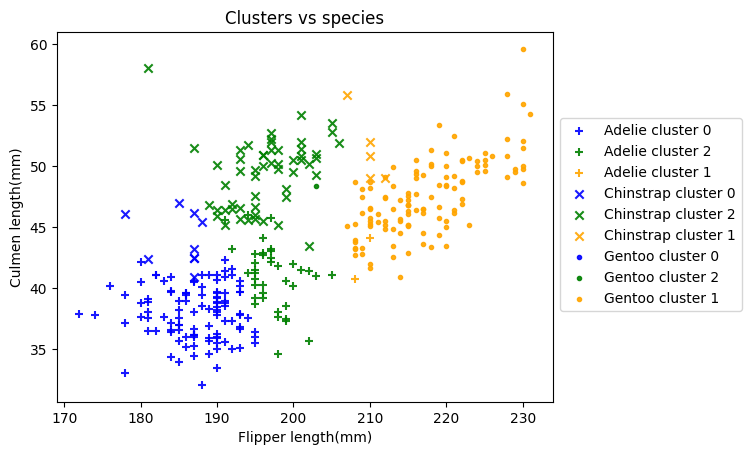

In [27]:
df_numonly_2cols = df[['culmen_length_mm', 'flipper_length_mm']]
kmeans = KMeans(n_clusters = df['species'].unique().size)
kmeans.fit(df_numonly_2cols)

# kmeans.labels_ contains the labels / classes / clusters assigned to each row.
# With some Python scripting we can create a plot that shows these classes in a graph.
# We create a new data frame that combines species name, assigned cluster and the
# columns used to do the classification
df_plot = pd.DataFrame(dict(
    species = df['species'],
    cluster = kmeans.labels_,
    culmen_length_mm = df['culmen_length_mm'],
    flipper_length_mm = df['flipper_length_mm'],
))
# df_plot
colors = ['blue', 'green', 'orange']
markers = ['+', 'x', '.']
marker_idx = 0
color_idx = 0
legend = []
fig, ax = plt.subplots()
for species in df_plot['species'].unique():
    marker = markers[marker_idx]
    marker_idx = marker_idx + 1
    color_idx = 0
    for cluster in df_plot['cluster'].unique():
        legend.append(species + ' cluster ' + str(cluster))
        df_species_cluster = df_plot[(df_plot['species'] == species) & (df_plot['cluster'] == cluster)]
        plt.scatter(df_species_cluster['flipper_length_mm'], df_species_cluster['culmen_length_mm'], alpha=0.9, color=colors[color_idx], marker=marker)
        color_idx += 1
    


ax.set_title("Clusters vs species")
ax.set_ylabel("Culmen length(mm)")
ax.set_xlabel("Flipper length(mm)")
fig.legend(legend, loc = 'center left', bbox_to_anchor=(0.9, 0.5))
plt.show()



It looks like the algorithm works quite well for Gentoo penguins, but has a tendency to mix up Adelie penguins and Chinstrap penguins. Interestingly, something similar happened with linear regression above: the score for the linear model was higher for Gentoo penguins than for the other two species.

It is possible to obtain better results by using more columns ("features") to determine the clusters. Unfortunately it will no longer be possible to show the result graphically.

Here we will use all numeric columns.

For each species we will show how many rows have been assigned to each cluster.

Note that every time you run the code below, the result changes. That has to do with the way the K-means algorithm works. There are ways to "lock" results, but those are outside of the scope of this notebook.

In [32]:
num_only_cols = ['culmen_length_mm', 'culmen_depth_mm',	'flipper_length_mm','body_mass_g']
df_numonly = df[num_only_cols]

kmeans = KMeans(n_clusters = df['species'].unique().size)
kmeans.fit(df_numonly)
df_cluster_vs_actual = pd.DataFrame(dict(cluster = kmeans.labels_, species = df['species']))
pd.pivot_table(df_cluster_vs_actual, values='cluster', columns='cluster', index=['species', 'cluster'], aggfunc={'cluster' : 'count'}).fillna(0)


cluster               0      1     2
species   cluster                   
Adelie    0        34.0    0.0   0.0
          1         0.0  112.0   0.0
Chinstrap 0        15.0    0.0   0.0
          1         0.0   53.0   0.0
Gentoo    0        58.0    0.0   0.0
          1         0.0    1.0   0.0
          2         0.0    0.0  61.0

### Supervised clustering: K-nearest neighbor

It is also possible to use clustering in supervised machine learning. In this case we tell the algorithm which column to predict ("species", in our case). It will try to find weights for the other columns that result in clusters that match the target column as closely as possible.

For this task, we will use the algorithm known as "K-nearest neighbor". "K-nearest" means each data point is considered to be in the same class as its "K" "nearest" neighbors.

As before, we will first use the flipper_length_mm and culmen_length_mm columns only so we can show the results in a graph and later use all numeric columns to see if that results in a better model.

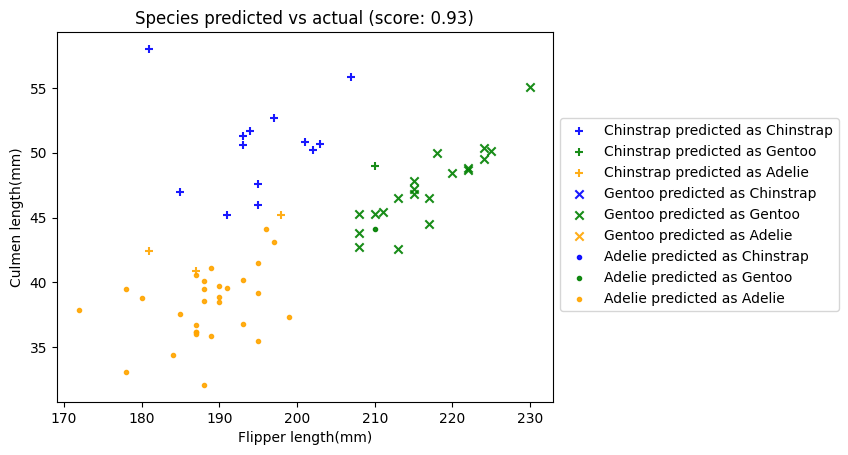

In [33]:
two_cols = ['flipper_length_mm', 'culmen_length_mm']
neighbor = KNeighborsClassifier()
neighbor.fit(df_train[two_cols], df_train['species'])

# Again, we will do some Python scripting to show a nice graph
df_plot = pd.DataFrame(dict(
    species = df_test['species'],
    predicted = neighbor.predict(df_test[two_cols]),
    culmen_length_mm = df_test['culmen_length_mm'],
    flipper_length_mm = df_test['flipper_length_mm'],
))
df_plot
colors = ['blue', 'green', 'orange']
markers = ['+', 'x', '.']
marker_idx = 0
color_idx = 0
legend = []
fig, ax = plt.subplots()
for species in df_plot['species'].unique():
    marker = markers[marker_idx]
    marker_idx = marker_idx + 1
    color_idx = 0
    for cluster in df_plot['predicted'].unique():
        legend.append(species + ' predicted as ' + str(cluster))
        df_species_cluster = df_plot[(df_plot['species'] == species) & (df_plot['predicted'] == cluster)]
        plt.scatter(df_species_cluster['flipper_length_mm'], df_species_cluster['culmen_length_mm'], alpha=0.9, color=colors[color_idx], marker=marker)
        color_idx += 1
    


ax.set_title(f"Species predicted vs actual (score: {neighbor.score(df_test[two_cols], df_test['species']):.2f})")
ax.set_ylabel("Culmen length(mm)")
ax.set_xlabel("Flipper length(mm)")
fig.legend(legend, loc = 'center left', bbox_to_anchor=(0.9, 0.5))
plt.show()


The score is pretty good. We can also see in the graph itself that most penguins are assigned the correct species.

Let's see if we can get an even higher score by adding the other numeric fields to the model.

In [34]:
neighbor = KNeighborsClassifier()
neighbor.fit(df_train[num_only_cols], df_train['species'])
print(f"Using all the numeric fields for the K-nearest neighbor classifier yields a score of {neighbor.score(df_test[num_only_cols], df_test['species']):.2f}")

Using all the numeric fields for the K-nearest neighbor classifier yields a score of 0.73


Unfortunately, adding more columns does not improve the model but instead makes it worse.